In [22]:
## libraries
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd
from tabulate import tabulate

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, first ,when
from PIL import Image
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, IntegerType,DoubleType
import io
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Suppress warning messages
import warnings
warnings.filterwarnings("ignore")


In [21]:
%pip install tensorflow
%pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 13.3 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 KB 5.7 MB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Initialize a Spark session
spark = SparkSession.builder.appName("EmotionDetection").getOrCreate()

In [3]:
file_path = "file:///home/hduser/Desktop/assesment/icml_face_data.csv"

# Read the data from the CSV file
data = spark.read.option("header", "true").csv(file_path)

# Show the first 10 rows of the DataFrame
data.show(10)

+-------+--------+--------------------+
|emotion|   Usage|              pixels|
+-------+--------+--------------------+
|      0|Training|70 80 82 72 58 58...|
|      0|Training|151 150 147 155 1...|
|      2|Training|231 212 156 164 1...|
|      4|Training|24 32 36 30 32 23...|
|      6|Training|4 0 0 0 0 0 0 0 0...|
|      2|Training|55 55 55 55 55 54...|
|      4|Training|20 17 19 21 25 38...|
|      3|Training|77 78 79 79 78 75...|
|      3|Training|85 84 90 121 101 ...|
|      2|Training|255 254 255 254 2...|
+-------+--------+--------------------+
only showing top 10 rows



In [4]:
# Check the data schema
data.printSchema()

root
 |-- emotion: string (nullable = true)
 |--  Usage: string (nullable = true)
 |--  pixels: string (nullable = true)



In [5]:
# Find the distinct emotions and count them
distinct_emotions = data.select("emotion").distinct()
emotions = distinct_emotions.count()

# Display the count of unique emotions
print("Number of unique emotions:", emotions)



Number of unique emotions: 7


In [6]:
# Group the data by the "emotion" column and count the occurrences of each emotion
emotion_counts = data.groupBy("emotion").count().orderBy("emotion")

# Show the emotion counts
emotion_counts.show()

+-------+-----+
|emotion|count|
+-------+-----+
|      0| 4953|
|      1|  547|
|      2| 5121|
|      3| 8989|
|      4| 6077|
|      5| 4002|
|      6| 6198|
+-------+-----+



In [7]:
data = spark.read.option("header", "false").csv(file_path)

# Rename the columns as needed
# You can replace the column names in the list with your desired column names
new_column_names = ["emotion", "Usage", "pixels"]
for i, new_name in enumerate(new_column_names):
    data = data.withColumnRenamed("_c" + str(i), new_name)

# Show the first few rows of the DataFrame
data.show()

+-------+--------+--------------------+
|emotion|   Usage|              pixels|
+-------+--------+--------------------+
|emotion|   Usage|              pixels|
|      0|Training|70 80 82 72 58 58...|
|      0|Training|151 150 147 155 1...|
|      2|Training|231 212 156 164 1...|
|      4|Training|24 32 36 30 32 23...|
|      6|Training|4 0 0 0 0 0 0 0 0...|
|      2|Training|55 55 55 55 55 54...|
|      4|Training|20 17 19 21 25 38...|
|      3|Training|77 78 79 79 78 75...|
|      3|Training|85 84 90 121 101 ...|
|      2|Training|255 254 255 254 2...|
|      0|Training|30 24 21 23 25 25...|
|      6|Training|39 75 78 58 58 45...|
|      6|Training|219 213 206 202 2...|
|      6|Training|148 144 130 129 1...|
|      3|Training|4 2 13 41 56 62 6...|
|      5|Training|107 107 109 109 1...|
|      3|Training|14 14 18 28 27 22...|
|      2|Training|255 255 255 255 2...|
|      6|Training|134 124 167 180 1...|
+-------+--------+--------------------+
only showing top 20 rows



In [8]:
# Filter out the first row (header row)
data = data.filter(col(data.columns[0]) != "emotion") 

# Show the DataFrame without the first row
data.show()

+-------+--------+--------------------+
|emotion|   Usage|              pixels|
+-------+--------+--------------------+
|      0|Training|70 80 82 72 58 58...|
|      0|Training|151 150 147 155 1...|
|      2|Training|231 212 156 164 1...|
|      4|Training|24 32 36 30 32 23...|
|      6|Training|4 0 0 0 0 0 0 0 0...|
|      2|Training|55 55 55 55 55 54...|
|      4|Training|20 17 19 21 25 38...|
|      3|Training|77 78 79 79 78 75...|
|      3|Training|85 84 90 121 101 ...|
|      2|Training|255 254 255 254 2...|
|      0|Training|30 24 21 23 25 25...|
|      6|Training|39 75 78 58 58 45...|
|      6|Training|219 213 206 202 2...|
|      6|Training|148 144 130 129 1...|
|      3|Training|4 2 13 41 56 62 6...|
|      5|Training|107 107 109 109 1...|
|      3|Training|14 14 18 28 27 22...|
|      2|Training|255 255 255 255 2...|
|      6|Training|134 124 167 180 1...|
|      4|Training|219 192 179 148 2...|
+-------+--------+--------------------+
only showing top 20 rows



In [9]:
# Group the data by the "Usage" column and count the occurrences of each unique value
usage_counts = data.groupBy("Usage").count()

# Show the usage counts
usage_counts.show()

+-----------+-----+
|      Usage|count|
+-----------+-----+
|   Training|28709|
| PublicTest| 3589|
|PrivateTest| 3589|
+-----------+-----+



In [10]:
# Group by 'emotion' and get the first row for each group
example_df = data.groupBy("emotion").agg(first("Usage").alias("Usage"), first("pixels").alias("pixels"))

example_df.show()

+-------+--------+--------------------+
|emotion|   Usage|              pixels|
+-------+--------+--------------------+
|      0|Training|70 80 82 72 58 58...|
|      1|Training|126 126 129 120 1...|
|      2|Training|231 212 156 164 1...|
|      3|Training|77 78 79 79 78 75...|
|      4|Training|24 32 36 30 32 23...|
|      5|Training|107 107 109 109 1...|
|      6|Training|4 0 0 0 0 0 0 0 0...|
+-------+--------+--------------------+



In [11]:
# Define a function to convert pixel values to an array of integers
def pixels_to_array(pixels):
    pixel_values = list(map(int, pixels.split()))
    return pixel_values

# Register the pixels_to_array function as a UDF
pixels_to_array_udf = udf(pixels_to_array, ArrayType(IntegerType()))


# Apply the UDF to create an additional column containing the pixel values as an array
example_df = example_df.withColumn("pixel_array", pixels_to_array_udf(example_df["pixels"]))

# Show the DataFrame with the added "pixel_array" column
example_df.show()

+-------+--------+--------------------+--------------------+
|emotion|   Usage|              pixels|         pixel_array|
+-------+--------+--------------------+--------------------+
|      0|Training|70 80 82 72 58 58...|[70, 80, 82, 72, ...|
|      1|Training|126 126 129 120 1...|[126, 126, 129, 1...|
|      2|Training|231 212 156 164 1...|[231, 212, 156, 1...|
|      3|Training|77 78 79 79 78 75...|[77, 78, 79, 79, ...|
|      4|Training|24 32 36 30 32 23...|[24, 32, 36, 30, ...|
|      5|Training|107 107 109 109 1...|[107, 107, 109, 1...|
|      6|Training|4 0 0 0 0 0 0 0 0...|[4, 0, 0, 0, 0, 0...|
+-------+--------+--------------------+--------------------+



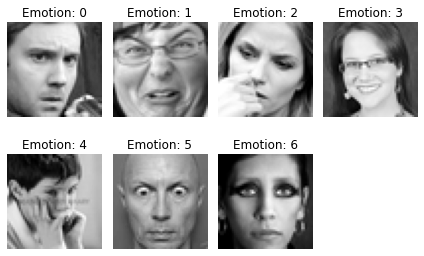

In [12]:
selected_row = example_df.limit(7).collect()

# Iterate through the selected rows and display each image
for i, selected_row in enumerate(selected_row):
    # Extract the pixel array from the selected row
    pixel_array = selected_row["pixel_array"]

    # Convert the pixel array to an image
    width, height = 48, 48  # Assuming a fixed image size of 48x48 pixels
    image = np.array(pixel_array).reshape(height, width)

    # Display the image
    plt.subplot(2, 4, i + 1)  # Create subplots for each image
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Hide axis labels
    plt.title(f'Emotion: {selected_row["emotion"]}')

plt.tight_layout()
plt.show()

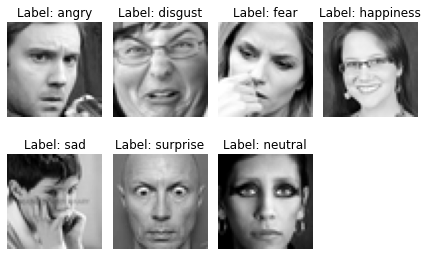

In [13]:

label_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

# Select the first 3 rows from the DataFrame
selected_rows = example_df.limit(7).collect()

# Iterate through the selected rows and display each image with the labeled emotion from the dictionary
for i, pixel_row in enumerate(selected_rows):
    # Extract the pixel array from the selected row
    pixel_array = pixel_row["pixel_array"]

    # Convert the pixel array to an image
    width, height = 48, 48  # Assuming a fixed image size of 48x48 pixels
    image = np.array(pixel_array).reshape(height, width)

    # Get the corresponding label text based on the index (0, 1, 2, etc.)
    emotion_text = label_dict.get(i, 'Unknown')

    # Display the image with the labeled emotion
    plt.subplot(2, 4, i + 1)  # Create subplots for each image
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Hide axis labels
    plt.title(f'Label: {emotion_text}')

plt.tight_layout()
plt.show()

In [14]:
#convert pixel column to array
# Apply the UDF to create an additional column containing the pixel values as an array
data = data.withColumn("pixels", pixels_to_array_udf(data["pixels"]))
data.show(5)

+-------+--------+--------------------+
|emotion|   Usage|              pixels|
+-------+--------+--------------------+
|      0|Training|[70, 80, 82, 72, ...|
|      0|Training|[151, 150, 147, 1...|
|      2|Training|[231, 212, 156, 1...|
|      4|Training|[24, 32, 36, 30, ...|
|      6|Training|[4, 0, 0, 0, 0, 0...|
+-------+--------+--------------------+
only showing top 5 rows



In [16]:
# Separate data based on the 'Usage' column
train_data = data.filter(data['Usage'] == 'Training')
test_data = data.filter(data['Usage'] == 'PublicTest')
val_data = data.filter(data['Usage'] == 'PrivateTest')

# Training Data
X_train = train_data.select('pixels')
y_train = train_data.select('emotion')

# Testing Data
X_test = test_data.select('pixels')
y_test = test_data.select('emotion')

# Validation Data
X_val = val_data.select('pixels')
y_val = val_data.select('emotion')

In [17]:
X_train = np.array(X_train.select("pixels").collect())
y_train = np.array(y_train.select("emotion").collect())

X_test = np.array(X_test.select("pixels").collect())
y_test = np.array(y_test.select("emotion").collect())

X_val = np.array(X_val.select("pixels").collect())
y_val = np.array(y_val.select("emotion").collect())




# Normalize pixel values 
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Reshape X_train and X_test 
X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
X_test = X_test.reshape((X_test.shape[0], 48, 48, 1))
X_val = X_val.reshape((X_val.shape[0], 48, 48, 1))

In [17]:
# Print the shape of the NumPy arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

# Print a sample of the contents (e.g., the first element)
print("Sample of X_train:", X_train[0])
print("Sample of X_test:", X_test[0])
print("Sample of X_val:", X_val[0])

X_train shape: (28709, 48, 48, 1)
X_test shape: (3589, 48, 48, 1)
X_val shape: (3589, 48, 48, 1)
Sample of X_train: [[[0.2745098 ]
  [0.31372549]
  [0.32156863]
  ...
  [0.20392157]
  [0.16862745]
  [0.16078431]]

 [[0.25490196]
  [0.23921569]
  [0.22745098]
  ...
  [0.21960784]
  [0.20392157]
  [0.17254902]]

 [[0.19607843]
  [0.16862745]
  [0.21176471]
  ...
  [0.19215686]
  [0.21960784]
  [0.18431373]]

 ...

 [[0.35686275]
  [0.25490196]
  [0.16470588]
  ...
  [0.28235294]
  [0.21960784]
  [0.16862745]]

 [[0.30196078]
  [0.32156863]
  [0.30980392]
  ...
  [0.41176471]
  [0.2745098 ]
  [0.18039216]]

 [[0.30196078]
  [0.28235294]
  [0.32941176]
  ...
  [0.41568627]
  [0.42745098]
  [0.32156863]]]
Sample of X_test: [[[0.99607843]
  [0.99607843]
  [0.99607843]
  ...
  [0.0627451 ]
  [0.        ]
  [0.63137255]]

 [[0.99607843]
  [0.99607843]
  [0.99607843]
  ...
  [0.06666667]
  [0.        ]
  [0.47843137]]

 [[0.99607843]
  [0.99607843]
  [0.99607843]
  ...
  [0.10196078]
  [0.     

In [18]:
# Print a sample of the contents
print("Sample of X_train:", X_train[0])

Sample of X_train: [[[0.2745098 ]
  [0.31372549]
  [0.32156863]
  ...
  [0.20392157]
  [0.16862745]
  [0.16078431]]

 [[0.25490196]
  [0.23921569]
  [0.22745098]
  ...
  [0.21960784]
  [0.20392157]
  [0.17254902]]

 [[0.19607843]
  [0.16862745]
  [0.21176471]
  ...
  [0.19215686]
  [0.21960784]
  [0.18431373]]

 ...

 [[0.35686275]
  [0.25490196]
  [0.16470588]
  ...
  [0.28235294]
  [0.21960784]
  [0.16862745]]

 [[0.30196078]
  [0.32156863]
  [0.30980392]
  ...
  [0.41176471]
  [0.2745098 ]
  [0.18039216]]

 [[0.30196078]
  [0.28235294]
  [0.32941176]
  ...
  [0.41568627]
  [0.42745098]
  [0.32156863]]]


In [18]:
#vectorise labels with one_hot_encoder
y_train = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=7)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=7)

In [19]:
# Get the length (number of rows) of the y_train DataFrame

# Print the length
print("Length of y_train:", y_train.shape)
print("Length of y_test:", y_test.shape)
print("Length of y_val:", y_val.shape)

Length of y_train: (28709, 7)
Length of y_test: (3589, 7)
Length of y_val: (3589, 7)


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = 7
# Define the CNN model for image data
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Adjust num_classes

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

2023-10-02 20:46:16.699585: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264582144 exceeds 10% of free system memory.


Epoch 1/10
898/898 [==============================] - 81s 88ms/step - loss: 1.5629 - accuracy: 0.3940 - val_loss: 1.4288 - val_accuracy: 0.4572
Epoch 2/10
898/898 [==============================] - 77s 86ms/step - loss: 1.3459 - accuracy: 0.4853 - val_loss: 1.3307 - val_accuracy: 0.4926
Epoch 3/10
898/898 [==============================] - 81s 91ms/step - loss: 1.2315 - accuracy: 0.5326 - val_loss: 1.2742 - val_accuracy: 0.5169
Epoch 4/10
898/898 [==============================] - 84s 94ms/step - loss: 1.1286 - accuracy: 0.5748 - val_loss: 1.2751 - val_accuracy: 0.5180
Epoch 5/10
898/898 [==============================] - 76s 85ms/step - loss: 1.0305 - accuracy: 0.6166 - val_loss: 1.2427 - val_accuracy: 0.5364
Epoch 6/10
898/898 [==============================] - 74s 83ms/step - loss: 0.9301 - accuracy: 0.6569 - val_loss: 1.3191 - val_accuracy: 0.5272
Epoch 7/10
898/898 [==============================] - 77s 86ms/step - loss: 0.8294 - accuracy: 0.6951 - val_loss: 1.3295 - val_accuracy:

In [34]:
new_data=data.filter(~col("emotion").isin([1, 2]))
# Define the conditions and new values
conditions = [(col("emotion") == 3, 1), (col("emotion") == 4, 2), (col("emotion") == 5, 3), (col("emotion") == 6, 4)]

# Use 'when' and 'otherwise' to update the column
for condition in conditions:
    new_data = new_data.withColumn("emotion", when(condition[0], condition[1]).otherwise(col("emotion")))


In [42]:
emotion_counts = new_data.groupBy("emotion").count().orderBy("emotion")

# Show the emotion counts
emotion_counts.show()

+-------+-----+
|emotion|count|
+-------+-----+
|      0| 4953|
|      1| 8989|
|      2| 6077|
|      3| 4002|
|      4| 6198|
+-------+-----+



In [43]:
#elem'nate dataset f'lter disgust and fear emotions
# Separate data based on the 'Usage' column

train_data = new_data.filter(new_data['Usage'] == 'Training')
test_data = new_data.filter(new_data['Usage'] == 'PublicTest')
val_data = new_data.filter(new_data['Usage'] == 'PrivateTest')

# Training Data
X_train = train_data.select('pixels')
y_train = train_data.select('emotion')

# Testing Data
X_test = test_data.select('pixels')
y_test = test_data.select('emotion')

# Validation Data
X_val = val_data.select('pixels')
y_val = val_data.select('emotion')


# to array
X_train = np.array(X_train.select("pixels").collect())
y_train = np.array(y_train.select("emotion").collect())

X_test = np.array(X_test.select("pixels").collect())
y_test = np.array(y_test.select("emotion").collect())

X_val = np.array(X_val.select("pixels").collect())
y_val = np.array(y_val.select("emotion").collect())


In [44]:
# Normalize pixel values 
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Reshape X_train and X_test 
X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
X_test = X_test.reshape((X_test.shape[0], 48, 48, 1))
X_val = X_val.reshape((X_val.shape[0], 48, 48, 1))

# Print the shape of the NumPy arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (24176, 48, 48, 1)
X_test shape: (3037, 48, 48, 1)
X_val shape: (3006, 48, 48, 1)


In [45]:
#vectorise labels with one_hot_encoder
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)


Length of y_train: (24176, 1)
Length of y_test: (24176, 1)


In [46]:
# Print the length
print("Length of y_train:", y_train.shape)
print("Length of y_test:", y_test.shape)

Length of y_train: (24176, 5)
Length of y_test: (3037, 5)


In [47]:
#modeling w'th new datasets
# Define constants and hyperparameters
num_classes = 5
input_shape = (48, 48, 1)
batch_size = 32
epochs = 30  # Increase the number of epochs
initial_learning_rate = 0.001  # Initial learning rate

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotate images for better generalization
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)



# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define a learning rate schedule
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,  # Optional: Print updates
)

# Data preprocessing and augmentation
train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)
val_datagen = datagen.flow(X_test, y_test, batch_size=batch_size)

# Train the model with data augmentation and the learning rate schedule
history = model.fit(
    train_datagen,
    epochs=epochs,
    validation_data=val_datagen,
    callbacks=[lr_scheduler],  # Add the learning rate schedule callback
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/30
756/756 [==============================] - 145s 187ms/step - loss: 1.8125 - accuracy: 0.3019 - val_loss: 1.4301 - val_accuracy: 0.3879 - lr: 0.0010
Epoch 2/30
756/756 [==============================] - 122s 162ms/step - loss: 1.4320 - accuracy: 0.4016 - val_loss: 1.3725 - val_accuracy: 0.4231 - lr: 0.0010
Epoch 3/30
756/756 [==============================] - 128s 169ms/step - loss: 1.3226 - accuracy: 0.4527 - val_loss: 1.3240 - val_accuracy: 0.4432 - lr: 0.0010
Epoch 4/30
756/756 [==============================] - 125s 165ms/step - loss: 1.2517 - accuracy: 0.4837 - val_loss: 1.2825 - val_accuracy: 0.4837 - lr: 0.0010
Epoch 5/30
756/756 [==============================] - 120s 159ms/step - loss: 1.2216 - accuracy: 0.4989 - val_loss: 1.1858 - val_accuracy: 0.5216 - lr: 0.0010
Epoch 6/30
756/756 [==============================] - 126s 166ms/step - loss: 1.1819 - accuracy: 0.5235 - val_loss: 1.2169 - val_accuracy: 0.5087 - lr: 0.0010
Epoch 7/30
756/756 [==========================

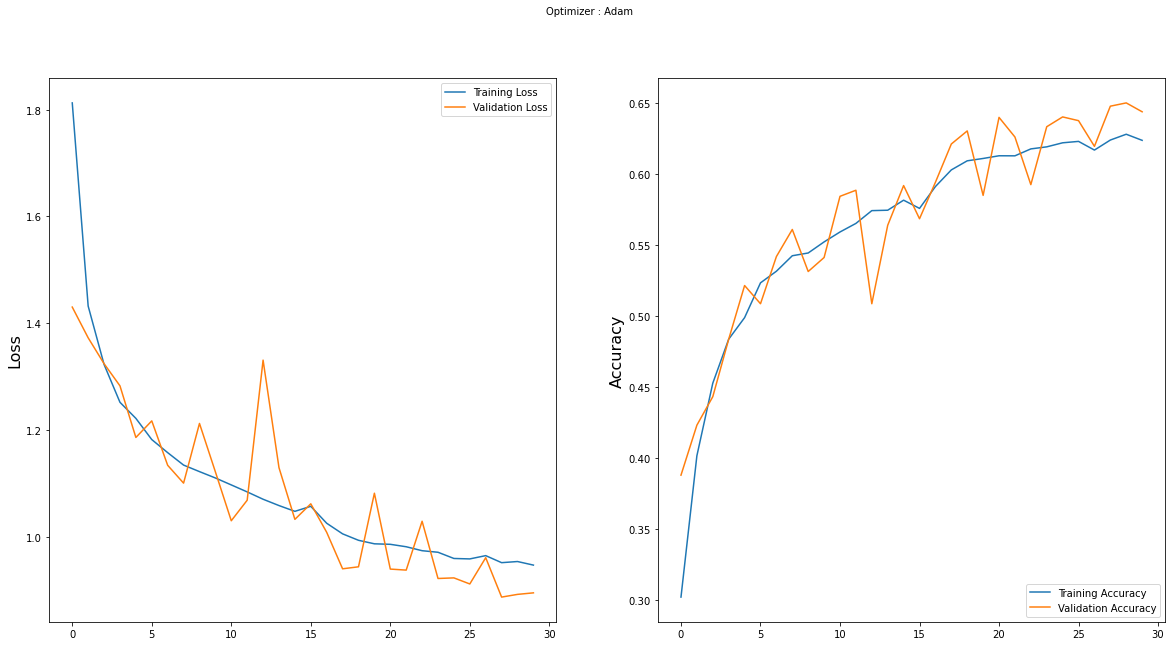

In [48]:
# Displas loss and accuracy
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [39]:
# for happy ,sad or neutral 
#label_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}
new_data=data.filter(~col("emotion").isin([0,1, 2,5]))
# Define the conditions and new values
conditions = [(col("emotion") == 3, 0), (col("emotion") == 4, 1), (col("emotion") == 6, 2)]

# Use 'when' and 'otherwise' to update the column
for condition in conditions:
    new_data = new_data.withColumn("emotion", when(condition[0], condition[1]).otherwise(col("emotion")))
    

# Separate data based on the 'Usage' column

train_data = new_data.filter(new_data['Usage'] == 'Training')
test_data = new_data.filter(new_data['Usage'] == 'PublicTest')
val_data = new_data.filter(new_data['Usage'] == 'PrivateTest')

# Training Data
X_train = train_data.select('pixels')
y_train = train_data.select('emotion')

# Testing Data
X_test = test_data.select('pixels')
y_test = test_data.select('emotion')

# Validation Data
X_val = val_data.select('pixels')
y_val = val_data.select('emotion')


# to array
X_train = np.array(X_train.select("pixels").collect())
y_train = np.array(y_train.select("emotion").collect())

X_test = np.array(X_test.select("pixels").collect())
y_test = np.array(y_test.select("emotion").collect())

X_val = np.array(X_val.select("pixels").collect())
y_val = np.array(y_val.select("emotion").collect())

# Normalize pixel values 
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Reshape X_train and X_test 
X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
X_test = X_test.reshape((X_test.shape[0], 48, 48, 1))
X_val = X_val.reshape((X_val.shape[0], 48, 48, 1))

# Print the shape of the NumPy arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

#vectorise labels with one_hot_encoder
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)

# Print the length
print("Length of y_train:", y_train.shape)
print("Length of y_test:", y_test.shape)


X_train shape: (17010, 48, 48, 1)
X_test shape: (2155, 48, 48, 1)
X_val shape: (2099, 48, 48, 1)
Length of y_train: (17010, 3)
Length of y_test: (2155, 3)


In [31]:
#modeling for 3 emotions
# Define constants and hyperparameters
num_classes = 3
input_shape = (48, 48, 1)
batch_size = 64
epochs = 30  # Increase the number of epochs
initial_learning_rate = 0.001  # Initial learning rate

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotate images for better generalization
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)



# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define a learning rate schedule
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,  # Optional: Print updates
)

# Data preprocessing and augmentation
train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)
val_datagen = datagen.flow(X_test, y_test, batch_size=batch_size)

# Train the model with data augmentation and the learning rate schedule
history = model.fit(
    train_datagen,
    epochs=epochs,
    validation_data=val_datagen,
    callbacks=[lr_scheduler],  # Add the learning rate schedule callback
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/30
266/266 [==============================] - 82s 295ms/step - loss: 1.4051 - accuracy: 0.4085 - val_loss: 1.6877 - val_accuracy: 0.4097 - lr: 0.0010
Epoch 2/30
266/266 [==============================] - 75s 282ms/step - loss: 1.0733 - accuracy: 0.4734 - val_loss: 1.2014 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 3/30
266/266 [==============================] - 73s 276ms/step - loss: 0.9779 - accuracy: 0.5181 - val_loss: 0.9921 - val_accuracy: 0.5383 - lr: 0.0010
Epoch 4/30
266/266 [==============================] - 74s 277ms/step - loss: 0.9208 - accuracy: 0.5526 - val_loss: 0.9016 - val_accuracy: 0.5796 - lr: 0.0010
Epoch 5/30
266/266 [==============================] - 79s 296ms/step - loss: 0.8703 - accuracy: 0.5835 - val_loss: 0.8463 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 6/30
266/266 [==============================] - 75s 281ms/step - loss: 0.8418 - accuracy: 0.5985 - val_loss: 0.8955 - val_accuracy: 0.5582 - lr: 0.0010
Epoch 7/30
266/266 [==============================] 

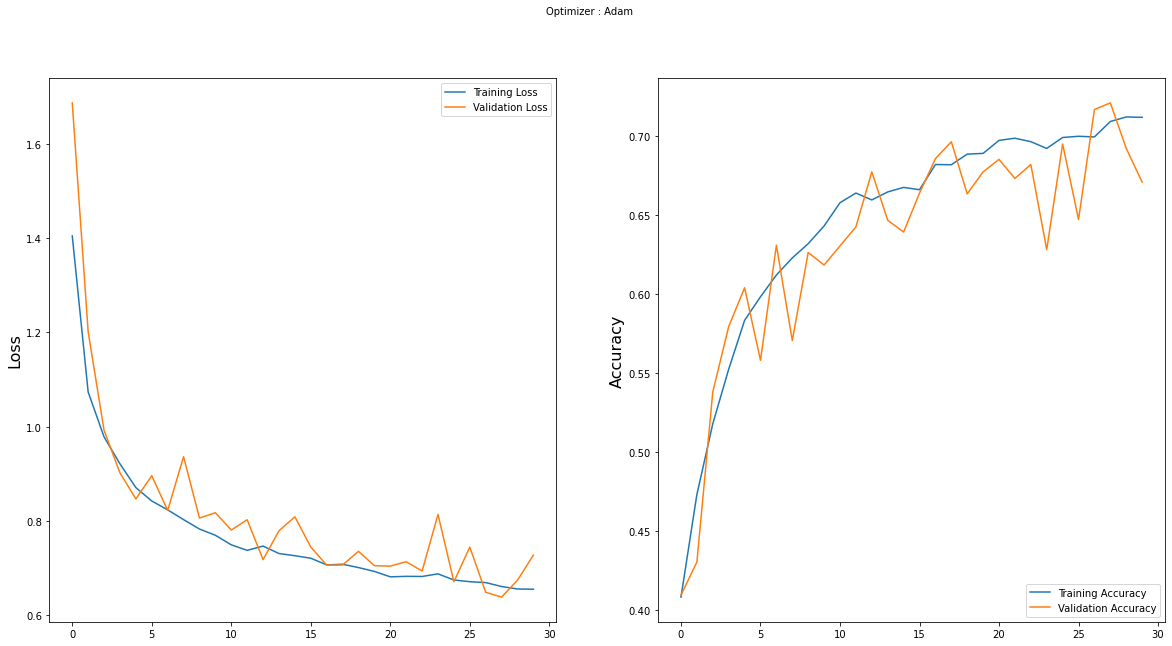

In [32]:
# Displas loss and accuracy
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [50]:
##0.01 learning rate
#modeling for 3 emotions
# Define constants and hyperparameters
num_classes = 3
input_shape = (48, 48, 1)
batch_size = 64
epochs = 30  # Increase the number of epochs
initial_learning_rate = 0.005  # Initial learning rate

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotate images for better generalization
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)



# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define a learning rate schedule
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,  # Optional: Print updates
)

# Data preprocessing and augmentation
train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)
val_datagen = datagen.flow(X_test, y_test, batch_size=batch_size)

# Train the model with data augmentation and the learning rate schedule
history = model.fit(
    train_datagen,
    epochs=epochs,
    validation_data=val_datagen,
    callbacks=[lr_scheduler],  # Add the learning rate schedule callback
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/30
266/266 [==============================] - 76s 270ms/step - loss: 1.3343 - accuracy: 0.3907 - val_loss: 1.1509 - val_accuracy: 0.3935 - lr: 0.0100
Epoch 2/30
266/266 [==============================] - 71s 268ms/step - loss: 1.1107 - accuracy: 0.4413 - val_loss: 1.1002 - val_accuracy: 0.4269 - lr: 0.0100
Epoch 3/30
266/266 [==============================] - 71s 267ms/step - loss: 1.0184 - accuracy: 0.4925 - val_loss: 1.1223 - val_accuracy: 0.4863 - lr: 0.0100
Epoch 4/30
266/266 [==============================] - 73s 272ms/step - loss: 0.9335 - accuracy: 0.5446 - val_loss: 1.1843 - val_accuracy: 0.3165 - lr: 0.0100
Epoch 5/30
266/266 [==============================] - 96s 359ms/step - loss: 0.9051 - accuracy: 0.5601 - val_loss: 1.1427 - val_accuracy: 0.3323 - lr: 0.0100
Epoch 6/30
266/266 [==============================] - 78s 294ms/step - loss: 0.8634 - accuracy: 0.5840 - val_loss: 0.8535 - val_accuracy: 0.5921 - lr: 0.0100
Epoch 7/30
266/266 [==============================] 

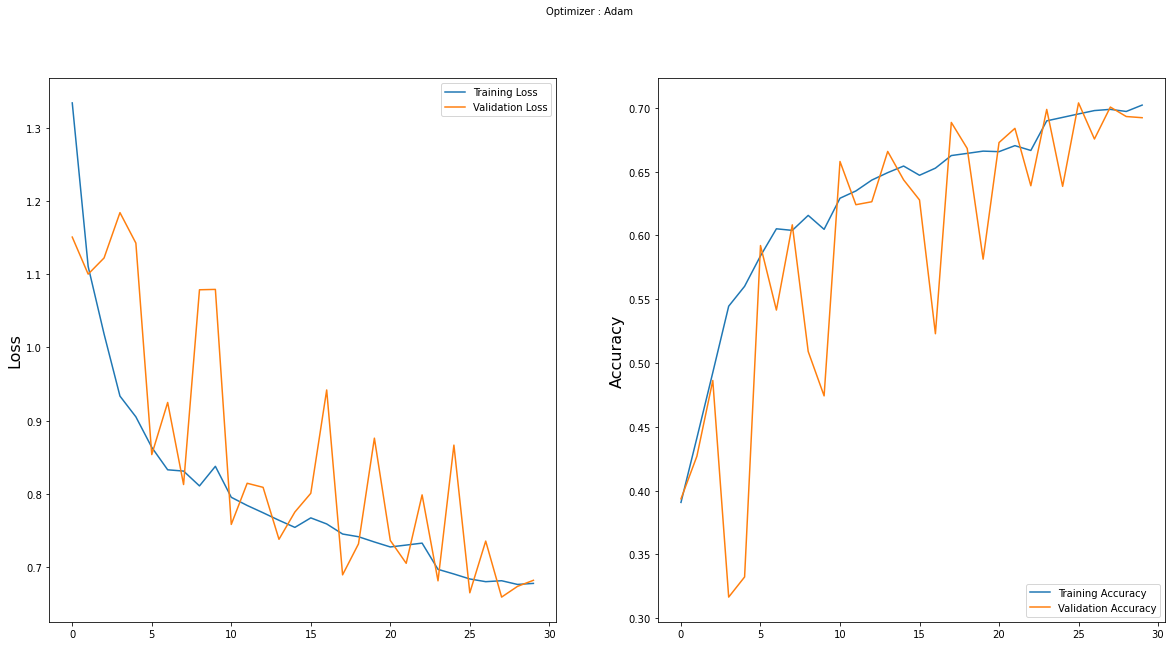

In [51]:
# Displas loss and accuracy
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [41]:
##0.005 learning rate
#patience 3
#batch 32
#epochs 50

num_classes = 3
input_shape = (48, 48, 1)
batch_size = 64
epochs = 50  # Increase the number of epochs
initial_learning_rate = 0.005  # Initial learning rate


# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define a learning rate schedule
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,  # Optional: Print updates
)

# Data preprocessing and augmentation
train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)
val_datagen = datagen.flow(X_test, y_test, batch_size=batch_size)


# Train the model 
history = model.fit(
    train_datagen,
    epochs=epochs,
    validation_data=val_datagen,
    callbacks=[lr_scheduler],  # Add the learning rate schedule callback
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/50
266/266 [==============================] - 108s 386ms/step - loss: 1.2475 - accuracy: 0.4354 - val_loss: 1.5505 - val_accuracy: 0.4200 - lr: 0.0050
Epoch 2/50
266/266 [==============================] - 104s 392ms/step - loss: 1.0730 - accuracy: 0.4761 - val_loss: 1.0390 - val_accuracy: 0.4747 - lr: 0.0050
Epoch 3/50
266/266 [==============================] - 102s 383ms/step - loss: 0.9827 - accuracy: 0.5206 - val_loss: 1.0346 - val_accuracy: 0.4947 - lr: 0.0050
Epoch 4/50
266/266 [==============================] - 60s 226ms/step - loss: 0.9312 - accuracy: 0.5474 - val_loss: 0.8809 - val_accuracy: 0.5805 - lr: 0.0050
Epoch 5/50
266/266 [==============================] - 61s 231ms/step - loss: 0.8783 - accuracy: 0.5815 - val_loss: 0.9958 - val_accuracy: 0.4974 - lr: 0.0050
Epoch 6/50
266/266 [==============================] - 58s 219ms/step - loss: 0.8517 - accuracy: 0.5966 - val_loss: 1.0000 - val_accuracy: 0.5044 - lr: 0.0050
Epoch 7/50
266/266 [=============================

266/266 [==============================] - 60s 225ms/step - loss: 0.6016 - accuracy: 0.7403 - val_loss: 0.6197 - val_accuracy: 0.7262 - lr: 6.2500e-04
Epoch 50/50
68/68 [==============================] - 1s 20ms/step - loss: 0.5622 - accuracy: 0.7517
Test Loss: 0.5622150301933289, Test Accuracy: 0.7517401576042175


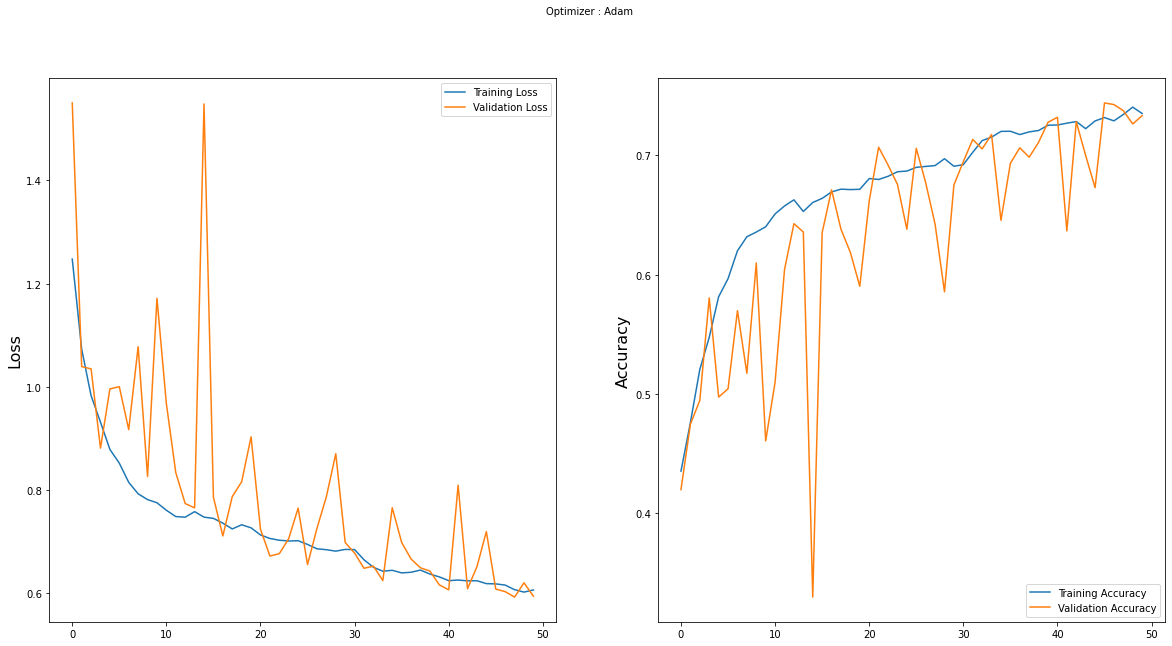

In [42]:
#d'splay new results
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [44]:

# Make predictions on the validation data
val_predictions = model.predict(X_val)
# Convert one-hot encoded labels back to categorical labels
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(y_val, axis=1)

# Calculate F1-scores for each class
f1_scores_per_class = f1_score(val_true_labels, val_pred_labels, average=None)

# Calculate overall F1-score (macro-average)
macro_f1_score = f1_score(val_true_labels, val_pred_labels, average='macro')

# Print F1-scores for each class and overall F1-score
for i, f1_score_class in enumerate(f1_scores_per_class):
    print(f"F1-score for class {i}: {f1_score_class}")

print(f"Overall F1-score (macro-average): {macro_f1_score}")

66/66 [==============================] - 2s 29ms/step
F1-score for class 0: 0.9016018306636155
F1-score for class 1: 0.6581118240146654
F1-score for class 2: 0.7137601177336276
Overall F1-score (macro-average): 0.7578245908039695


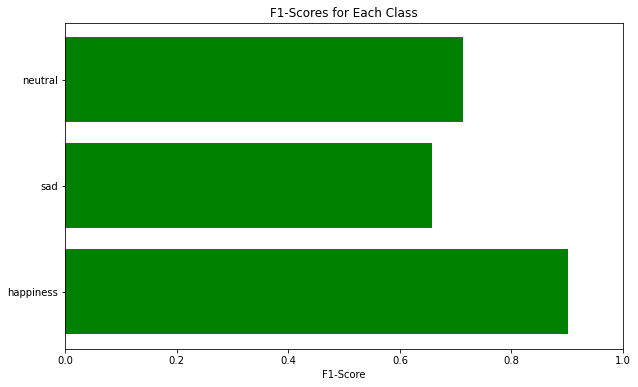

In [45]:
label_dict = {0:'happiness', 1: 'sad', 2: 'neutral'}

# Map the class labels to their corresponding F1-scores
f1_scores_by_class = {label_dict[i]: f1_scores_per_class[i] for i in range(len(f1_scores_per_class))}

# Extract labels and scores
labels = list(f1_scores_by_class.keys())
scores = list(f1_scores_by_class.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, scores, color='green')
plt.xlabel('F1-Score')
plt.title('F1-Scores for Each Class')
plt.xlim(0, 1)  # Set the x-axis limit from 0 to 1 for F1-score range

# Display the bar chart
plt.show()

In [47]:

# Create a dictionary to store the metrics
metrics_dict = {
    'Emotion': [label_dict[i] for i in range(len(f1_scores_per_class))],
    'Accuracy': [accuracy_score(val_true_labels, val_pred_labels) for _ in range(len(f1_scores_per_class))],
    'Recall': [recall_score(val_true_labels, val_pred_labels, average=None)[i] for i in range(len(f1_scores_per_class))],
    'Precision': [precision_score(val_true_labels, val_pred_labels, average=None)[i] for i in range(len(f1_scores_per_class))],
    'F1-Score': [f1_scores_per_class[i] for i in range(len(f1_scores_per_class))],
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Display the table-like structure
print(metrics_df)

     Emotion  Accuracy    Recall  Precision  F1-Score
0  happiness  0.777513  0.896473   0.906789  0.901602
1        sad  0.777513  0.604377   0.722334  0.658112
2    neutral  0.777513  0.774760   0.661664  0.713760


In [15]:

# Separate orginal data based on the 'Usage' column again for 5 classes
new_data=data.filter(~col("emotion").isin([1, 2]))
# Define the conditions and new values
conditions = [(col("emotion") == 3, 1), (col("emotion") == 4, 2), (col("emotion") == 5, 3), (col("emotion") == 6, 4)]

# Use 'when' and 'otherwise' to update the column
for condition in conditions:
    new_data = new_data.withColumn("emotion", when(condition[0], condition[1]).otherwise(col("emotion")))

train_data = new_data.filter(data['Usage'] == 'Training')
test_data = new_data.filter(data['Usage'] == 'PublicTest')
val_data = new_data.filter(data['Usage'] == 'PrivateTest')

# Training Data
X_train = train_data.select('pixels')
y_train = train_data.select('emotion')

# Testing Data
X_test = test_data.select('pixels')
y_test = test_data.select('emotion')

# Validation Data
X_val = val_data.select('pixels')
y_val = val_data.select('emotion')


# to array
X_train = np.array(X_train.select("pixels").collect())
y_train = np.array(y_train.select("emotion").collect())

X_test = np.array(X_test.select("pixels").collect())
y_test = np.array(y_test.select("emotion").collect())

X_val = np.array(X_val.select("pixels").collect())
y_val = np.array(y_val.select("emotion").collect())

# Normalize pixel values 
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Reshape X_train and X_test 
X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
X_test = X_test.reshape((X_test.shape[0], 48, 48, 1))
X_val = X_val.reshape((X_val.shape[0], 48, 48, 1))

# Print the shape of the NumPy arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

#vectorise labels with one_hot_encoder
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)

# Print the length
print("Length of y_train:", y_train.shape)
print("Length of y_test:", y_test.shape)



X_train shape: (24176, 48, 48, 1)
X_test shape: (3037, 48, 48, 1)
X_val shape: (3006, 48, 48, 1)
Length of y_train: (24176, 5)
Length of y_test: (3037, 5)


In [17]:
#running last model with all 5 classes again
#starting learning rate 0.05

##0.005 learning rate
#patience 3
#batch 64
#epochs 30



num_classes = 5
input_shape = (48, 48, 1)
batch_size = 64
epochs = 30  
initial_learning_rate = 0.005  # Initial learning rate

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotate images for better generalization
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)



# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define a learning rate schedule
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,  
)

# Data preprocessing and augmentation
train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)
val_datagen = datagen.flow(X_test, y_test, batch_size=batch_size)

# Train the model 
history = model.fit(
    train_datagen,
    epochs=epochs,
    validation_data=val_datagen,
    callbacks=[lr_scheduler],  # Add the learning rate schedule callback
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")



Epoch 1/30
378/378 [==============================] - 114s 293ms/step - loss: 1.7219 - accuracy: 0.3166 - val_loss: 1.9847 - val_accuracy: 0.2667 - lr: 0.0050
Epoch 2/30
378/378 [==============================] - 87s 231ms/step - loss: 1.4516 - accuracy: 0.3951 - val_loss: 1.5075 - val_accuracy: 0.3214 - lr: 0.0050
Epoch 3/30
378/378 [==============================] - 90s 239ms/step - loss: 1.3256 - accuracy: 0.4526 - val_loss: 1.4420 - val_accuracy: 0.4076 - lr: 0.0050
Epoch 4/30
378/378 [==============================] - 181s 480ms/step - loss: 1.2379 - accuracy: 0.4928 - val_loss: 1.4367 - val_accuracy: 0.4363 - lr: 0.0050
Epoch 5/30
378/378 [==============================] - 184s 487ms/step - loss: 1.1893 - accuracy: 0.5133 - val_loss: 1.1602 - val_accuracy: 0.5295 - lr: 0.0050
Epoch 6/30
378/378 [==============================] - 168s 445ms/step - loss: 1.1678 - accuracy: 0.5208 - val_loss: 1.5453 - val_accuracy: 0.3240 - lr: 0.0050
Epoch 7/30
378/378 [============================

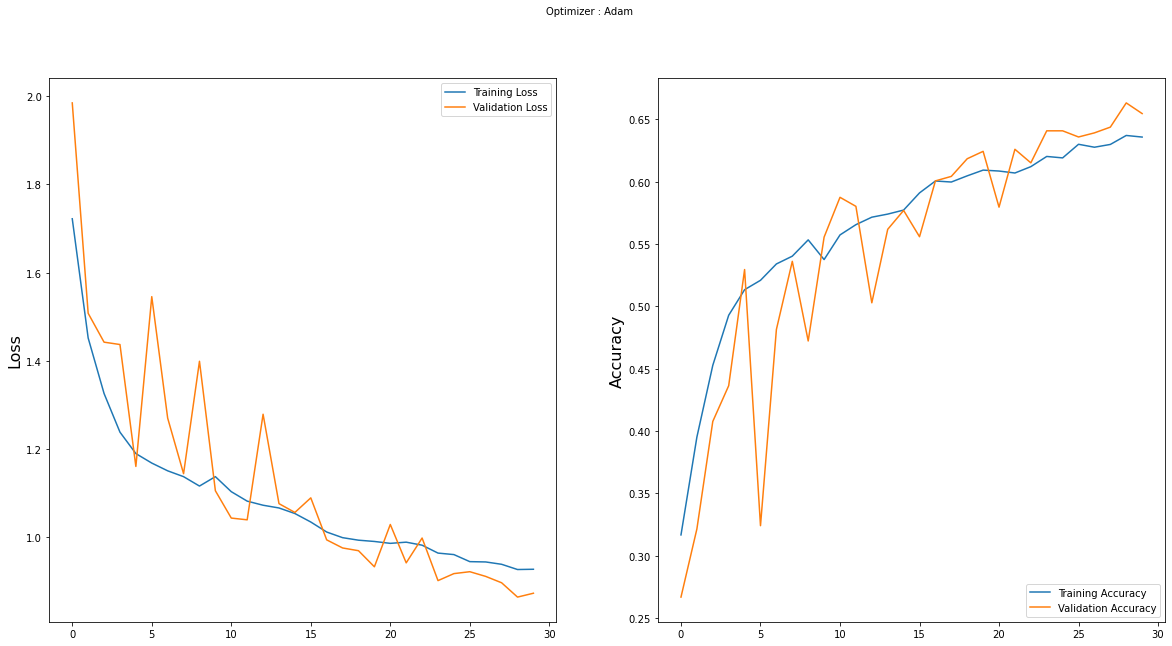

In [18]:
#display last results
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [23]:


# Make predictions on the validation data
val_predictions = model.predict(X_val)
# Convert one-hot encoded labels back to categorical labels
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(y_val, axis=1)

# Calculate F1-scores for each class
f1_scores_per_class = f1_score(val_true_labels, val_pred_labels, average=None)

# Calculate overall F1-score (macro-average)
macro_f1_score = f1_score(val_true_labels, val_pred_labels, average='macro')

# Print F1-scores for each class and overall F1-score
for i, f1_score_class in enumerate(f1_scores_per_class):
    print(f"F1-score for class {i}: {f1_score_class}")

print(f"Overall F1-score (macro-average): {macro_f1_score}")



94/94 [==============================] - 9s 83ms/step
F1-score for class 0: 0.6215316315205328
F1-score for class 1: 0.8491803278688524
F1-score for class 2: 0.5443583118001722
F1-score for class 3: 0.8067226890756302
F1-score for class 4: 0.6216006216006217
Overall F1-score (macro-average): 0.6886787163731618


In [46]:

# Create a dictionary to store the metrics
metrics_dict = {
    'Emotion': [label_dict[i] for i in range(len(f1_scores_per_class))],
    'Accuracy': [accuracy_score(val_true_labels, val_pred_labels) for _ in range(len(f1_scores_per_class))],
    'Recall': [recall_score(val_true_labels, val_pred_labels, average=None)[i] for i in range(len(f1_scores_per_class))],
    'Precision': [precision_score(val_true_labels, val_pred_labels, average=None)[i] for i in range(len(f1_scores_per_class))],
    'F1-Score': [f1_scores_per_class[i] for i in range(len(f1_scores_per_class))],
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Display the table-like structure
print(metrics_df)

     Emotion  Accuracy    Recall  Precision  F1-Score
0  happiness  0.777513  0.896473   0.906789  0.901602
1        sad  0.777513  0.604377   0.722334  0.658112
2    neutral  0.777513  0.774760   0.661664  0.713760


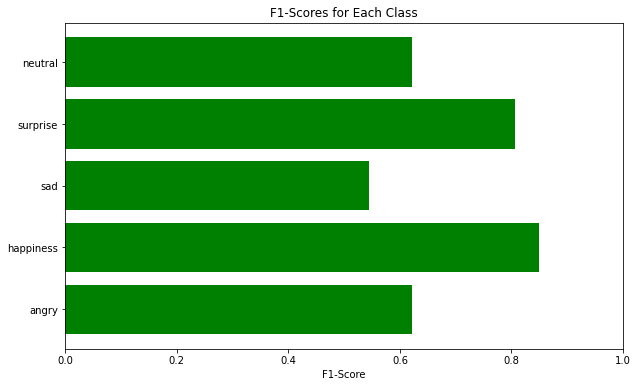

In [28]:
label_dict = {0: 'angry', 1:'happiness', 2: 'sad', 3: 'surprise', 4: 'neutral'}

# Map the class labels to their corresponding F1-scores
f1_scores_by_class = {label_dict[i]: f1_scores_per_class[i] for i in range(len(f1_scores_per_class))}

# Extract labels and scores
labels = list(f1_scores_by_class.keys())
scores = list(f1_scores_by_class.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, scores, color='green')
plt.xlabel('F1-Score')
plt.title('F1-Scores for Each Class')
plt.xlim(0, 1)  # Set the x-axis limit from 0 to 1 for F1-score range

# Display the bar chart
plt.show()

In [37]:
print(val_pred_labels)


[0 2 2 ... 1 2 1]


In [32]:

#  label_dict 
label_dict = {0: 'angry', 1:'happiness', 2: 'sad', 3: 'surprise', 4: 'neutral'}


# Create a dictionary to store the metrics
metrics_dict = {
    'Emotion': [label_dict[i] for i in range(len(f1_scores_per_class))],
    'Accuracy': [accuracy_score(val_true_labels, val_pred_labels) for _ in range(len(f1_scores_per_class))],
    'Recall': [recall_score(val_true_labels, val_pred_labels, average=None)[i] for i in range(len(f1_scores_per_class))],
    'Precision': [precision_score(val_true_labels, val_pred_labels, average=None)[i] for i in range(len(f1_scores_per_class))],
    'F1-Score': [f1_scores_per_class[i] for i in range(len(f1_scores_per_class))],
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Display the table-like structure
print(metrics_df)



     Emotion  Accuracy    Recall  Precision  F1-Score
0      angry  0.701597  0.570265   0.682927  0.621532
1  happiness  0.701597  0.883959   0.817035  0.849180
2        sad  0.701597  0.531987   0.557319  0.544358
3   surprise  0.701597  0.807692   0.805755  0.806723
4    neutral  0.701597  0.638978   0.605144  0.621601


In [31]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 9.8 MB/s eta 0:00:000m eta 0:00:010:0101
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 KB 10.7 MB/s eta 0:00:0031m19.8 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 KB 20.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [33]:
%pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:


# Use tabulate to display the Pandas DataFrame as a nicely formatted table
table = tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False)

# Print the table
print(table)

+-----------+--------------------+--------------------+--------------------+--------------------+
|  Emotion  |      Accuracy      |       Recall       |     Precision      |      F1-Score      |
+-----------+--------------------+--------------------+--------------------+--------------------+
|   angry   | 0.7015968063872255 | 0.570264765784114  | 0.6829268292682927 | 0.6215316315205328 |
| happiness | 0.7015968063872255 | 0.8839590443686007 | 0.8170347003154574 | 0.8491803278688524 |
|    sad    | 0.7015968063872255 | 0.531986531986532  | 0.5573192239858906 | 0.5443583118001722 |
| surprise  | 0.7015968063872255 | 0.8076923076923077 | 0.8057553956834532 | 0.8067226890756302 |
|  neutral  | 0.7015968063872255 | 0.6389776357827476 | 0.6051437216338881 | 0.6216006216006217 |
+-----------+--------------------+--------------------+--------------------+--------------------+


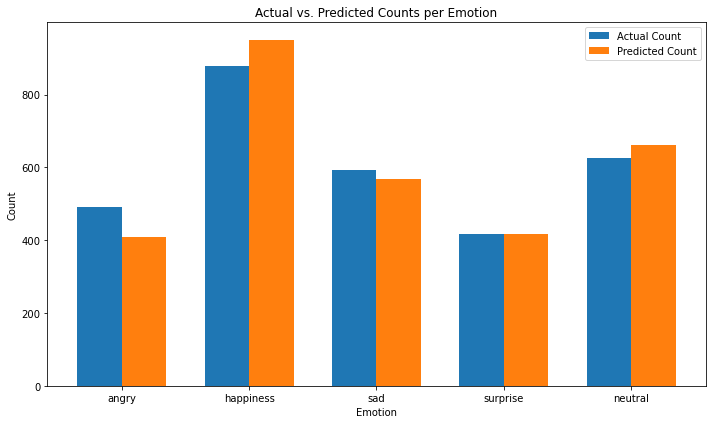

In [36]:

#val_pred_labels = np.argmax(val_predictions, axis=1)
#val_true_labels = np.argmax(y_val, axis=1)
emotion_counts = {}
for emotion in label_dict.values():
    emotion_counts[emotion] = {
        'Actual Count': np.sum(val_true_labels == [i for i, label in enumerate(label_dict.values()) if label == emotion]),
        'Predicted Count': np.sum(val_pred_labels == [i for i, label in enumerate(label_dict.values()) if label == emotion])
    }

# Convert the dictionary to a Pandas DataFrame for easy plotting
emotion_counts_df = pd.DataFrame(emotion_counts).transpose()

# Create a bar chart to compare actual and predicted counts per emotion
plt.figure(figsize=(10, 6))
x = np.arange(len(emotion_counts_df.index))
bar_width = 0.35

plt.bar(x - bar_width/2, emotion_counts_df['Actual Count'], bar_width, label='Actual Count')
plt.bar(x + bar_width/2, emotion_counts_df['Predicted Count'], bar_width, label='Predicted Count')

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Actual vs. Predicted Counts per Emotion')
plt.xticks(x, emotion_counts_df.index)
plt.legend()
plt.tight_layout()

# Show the bar chart
plt.show()

In [20]:
spark.stop()